In [6]:
import numpy as np
import pandas as pd

In [2]:
cc_df= pd.read_csv('creditcard.csv')

In [3]:
cc_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
cc_df.shape

(284807, 31)

The determination of whether this transaction is determined to be legitimate or fraudulent is encoded in the 'Class' field:

In [5]:
cc_df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [6]:
type(cc_df['Class'].value_counts())

pandas.core.series.Series

In [1]:
import sys

In [2]:
sys.path.append('deep_tabular_augmentation')
sys.path.append('ml_prepare')

In [3]:
import mlprepare as mlp
import deep_tabular_augmentation as dta

In [7]:
wine_df = pd.read_csv('wine.csv')

In [8]:
wine_df.head()

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [9]:
wine_df.shape

(178, 14)

In [10]:
wine_df = wine_df.fillna(-99)

In [11]:
wine_df.columns

Index(['Wine', 'Alcohol', 'Malic.acid', 'Ash', 'Acl', 'Mg', 'Phenols',
       'Flavanoids', 'Nonflavanoid.phenols', 'Proanth', 'Color.int', 'Hue',
       'OD', 'Proline'],
      dtype='object')

In [18]:
wine_df['Wine'].value_counts()

2    71
1    59
3    48
Name: Wine, dtype: int64

In [19]:
X_train, X_test, y_train, y_test = mlp.split_df(wine_df, dep_var='Wine', test_size=0.3, split_mode='random')

In [20]:
type(X_train)

pandas.core.frame.DataFrame

In [21]:
from sklearn.preprocessing import StandardScaler
from functools import partial

In [22]:
x_scaler = StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train)

X_test_scaled = x_scaler.transform(X_test)

In [33]:
datasets = dta.create_datasets(X_train.values, y_train.values, X_test.values, y_test.values)

In [34]:
data = dta.DataBunch(*dta.create_loaders(datasets, bs=1024))

In [43]:
import torch
from torch import nn
from torch import optim

In [44]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [45]:
D_in = X_train.values.shape[1]

model = dta.Autoencoder(nn.Sequential(*dta.get_lin_layers(D_in, [50, 12, 12])),
                     nn.Sequential(*dta.get_lin_layers_rev(D_in, [50, 12, 12])),
                     latent_dim=5).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
loss_func = dta.customLoss()

In [46]:
learn = dta.Learner(model, opt, loss_func, data, 'Wine', 1, list(wine_df.columns))

In [47]:
run = dta.Runner(cb_funcs=[dta.LR_Find, dta.Recorder])

run.fit(100, learn)

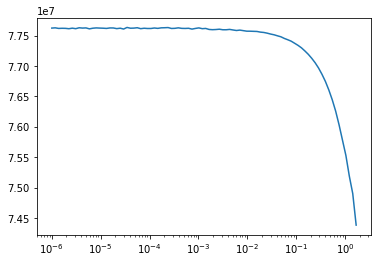

In [48]:
run.recorder.plot(skip_last=5)

In [49]:
sched = dta.combine_scheds([0.3, 0.7], [dta.sched_cos(0.01, 0.05), dta.sched_cos(0.05, 0.01)])

In [50]:
cbfs = [partial(dta.LossTracker, show_every=200), dta.Recorder, partial(dta.ParamScheduler, 'lr', sched)]
model = dta.Autoencoder(nn.Sequential(*dta.get_lin_layers(D_in, [50, 12, 12])),
                     nn.Sequential(*dta.get_lin_layers_rev(D_in, [50, 12, 12])),
                     latent_dim=5).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
learn = dta.Learner(model, opt, loss_func, data, 'Wine', 1, list(wine_df.columns))
run = dta.Runner(cb_funcs=cbfs)
run.fit(1000, learn)

epoch: 200
train loss is: 77617392.0
validation loss is: 41136336.0
epoch: 400
train loss is: 77062208.0
validation loss is: 40781008.0
epoch: 600
train loss is: 76013888.0
validation loss is: 40141120.0
epoch: 800
train loss is: 74828056.0
validation loss is: 39454640.0
epoch: 1000
train loss is: 73792480.0
validation loss is: 38906524.0


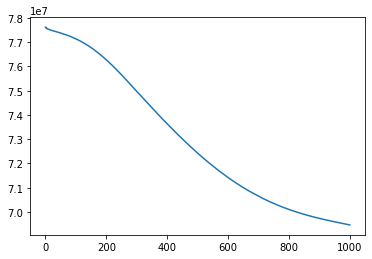

In [51]:
run.recorder.plot_loss()

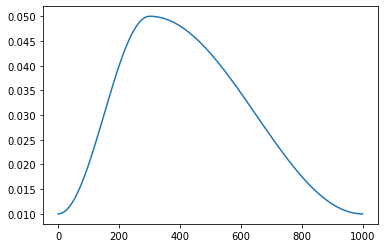

In [52]:
run.recorder.plot_lr()

In [53]:
df_fake = run.predict_df(learn, no_samples=10000, scaler=x_scaler)

In [54]:
df_fake.head()

,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline,Wine
0,22.892912,6.214776,2.959596,78.549812,382.422394,3.513761,3.493565,0.413844,2.518454,17.914984,1.180802,4.263325,10140.697266,1
1,23.137306,7.038565,2.968955,83.001312,425.197388,3.410734,2.904607,0.421795,2.412798,22.436054,1.161304,3.928234,10220.760742,1
2,22.971836,6.456391,2.966599,79.572250,404.819122,3.521802,3.375032,0.417210,2.539556,19.578526,1.172795,4.185929,10077.402344,1
3,22.985029,6.537673,2.962857,79.446075,396.883759,3.484412,3.331198,0.416296,2.535131,19.596266,1.168882,4.183113,10175.490234,1
4,23.054363,6.803229,2.966936,80.915108,414.160645,3.458214,3.134643,0.419457,2.466407,20.863850,1.165729,4.060224,10155.515625,1


In [55]:
wine_df.head()

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [56]:
model.state_dict

<bound method Module.state_dict of Autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=13, out_features=50, bias=True)
      (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=50, out_features=12, bias=True)
      (1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=12, out_features=12, bias=True)
      (1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (fc1): Linear(in_features=12, out_features=5, bias=True)
  (bn1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc21): Linear(in_features=5, out_features=5, bias=True)
  (fc22): Linear(in_features=5, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=5, bias=True)
  (fc_